# TP Compressed Sensing for MR Images

Diana Mateus



Participants: 

* Yassine Jamoud
* Saâd Aziz Alaoui
* Samy Haffoudhi

### GOAL
This notebook explores one of the most useful applications of compressed sensing, namely Magnetic Resonance Image (MRI) reconstruction. 

We will use the SigPy module, and this notebook is partly inspired on the module's tutorial. 

There will two datasets to explore:

- The first is a controlled dataset for which we have a ground truth digital **phantom** image.
- The second is a multi-channel data from the ISMRM reproducible challenge (Source: Martin Uecker). The dataset contains k-space measurements of an **in-vivo brain** scan acquired with a projection reconstruction trajectory. 


### References

You can refer to the next links to search the answer of some of the questions

- An old but very useful site about the MR Imaging is https://www.mr-tip.com, here you will find definitions of all the MRI specific terms, the parallel acquisition and also of some of the methods. 

- A complete website about MRI in questions and answers http://mriquestions.com/complete-list-of-questions.html 

- The original scientific papers regarding the new methods (other than classical inv problems algorithms)

    - [Sense](https://www.physast.uga.edu/classes/phys8900/qzhao/PDF8500_08/SENSE.pdf)
    - [Espirit](https://onlinelibrary.wiley.com/doi/pdf/10.1002/mrm.24751)
    
- [SigPy documentation](https://sigpy.readthedocs.io) 

- Do not hesitate to find and cite your own sources (papers, blogs, tutorials or videos)

### Requirements
Install the required module Sigpy and load modules and functions
    

In [1]:
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import matplotlib.pyplot as plt
from math import log10, sqrt 
from sigpy.mri import poisson, spiral,radial
import sigpy.mri as mr

In [2]:
def multiChannelPhantomKspace(shape =(256,256), nchannels=1):

    #loading the logan phantom
    logan = sp.shepp_logan(shape)

    #copying the fft of the phantom on the different channels
    logan_multi = np.zeros((nchannels,shape[0],shape[1]),dtype=np.complex_)
    logan_multi_ksp = np.zeros((nchannels,shape[0],shape[1]),dtype=np.complex_)
    ksp = sp.fft(logan)
    
    for i in range(nchannels):
        logan_multi[i,:,:]= logan
        logan_multi_ksp[i,:,:]= ksp
    return logan_multi_ksp



In [3]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):    #  MSE is zero means no noise is present in the signal . 
        return -100  #  Therefore PSNR is irrelevant
    max_pixel = original.max()
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr 

## 1. Datasets

### 1. Visualizing and preparing the datasets

#### 1.1.  K-space:

a) Visualize the **phantom** dataset with a single channel. 

b) Visualize the **invivo brain** dataset with multiple channels.

c) What do the images show? What do the values in the K-Space stand for?
     
    

    

### 1.1. K-space

#### a)

In [4]:
#load phantom data

ksp_phantom = multiChannelPhantomKspace(nchannels=1)

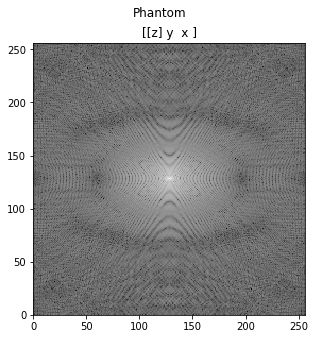

In [10]:
# Visualization

pl.ImagePlot(np.log(np.abs(ksp_phantom)+1e-16), z=0, title='Phantom')

plt.show()

#### b)

In [7]:
# load the in-vivo data
ksp = np.load('cartesian_ksp.npy')

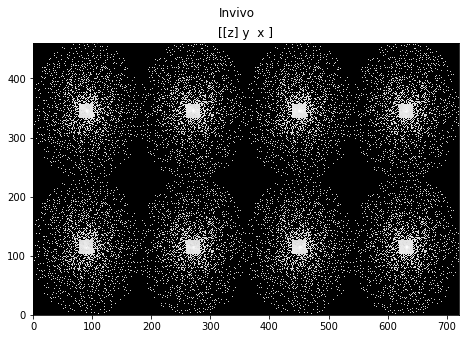

In [11]:
# Visualizing the invivo data
plt.rcParams["figure.figsize"] = (10,5)

# Fill in
pl.ImagePlot(np.log(np.abs(ksp)+1e-16), z=0, title='Invivo')

sample_invivo = np.abs(ksp[0])

#### c)

On observe les signaux bruts fournis par la machine, c'est-à-dire, des transformées de Fourier. Les valeurs correspondent alors à des coefficients de transformée de Fourier. On passe en valeur absolue afin de pouvoir afficher des images et on utilise le log afin d'augmenter la lisibilité.

##  2. Reconstruction of the full phantom data



### 2. Reconstruction of the full phantom data

**2.1.** How do we reconstruct the MRI data from a single fully sampled k-space? 
    
**2.2.** Implement and show the results of reconstructing the **phantom** image from the fully sampled data
    
**2.3.** Compute the wavelet transform of the fully reconstructed image. Why is the wavelet transform a good choice for CS? demonstrate by showing the histogram of the wavelet coefficients ordered from the largest to the smallest.




### 2.1.

Pour la reconstruction, on applique la transformée de fourier inverse.

### 2.2

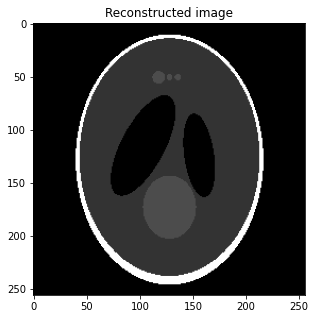

In [19]:
image_recons = np.abs(sp.ifft(ksp_phantom, axes=(-1,-2)))[0]

plt.imshow(image_recons, cmap='gray')
plt.title('Reconstructed image')

plt.show()

### 2.3

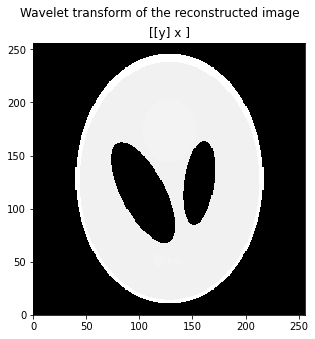

In [20]:
fwt = sp.fwt(image_recons)
fwt_log = np.log(np.abs(image_recons) + 10**-12)

pl.ImagePlot(fwt_log, title='Wavelet transform of the reconstructed image')

La transformée en ondelettes est un choix intéressant pour le CS. En effet, la plupart des coefficients sont nuls (parcimonie). En sachant desquels il s'agit, on peut uniquement acquérier les autres, non nuls.

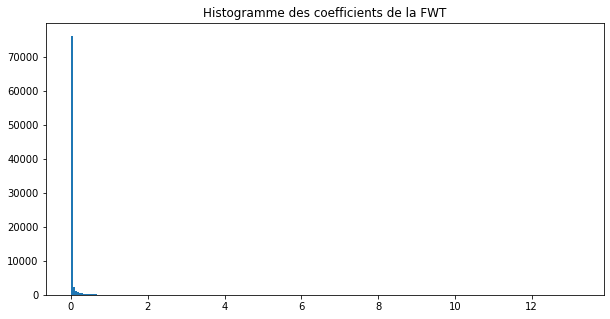

In [21]:
fwt = fwt.flatten()
fwt_sorted = sorted(abs(fwt))[::-1]

plt.hist(fwt_sorted, bins=256)
plt.title('Histogramme des coefficients de la FWT')

plt.show()

On voit que la majorité des coefficients sont effectivement nuls.

## 3. Compressed Sensing on phantom data

### 3.1

Creating mask (./mask_logan_r6_c20.npy)...


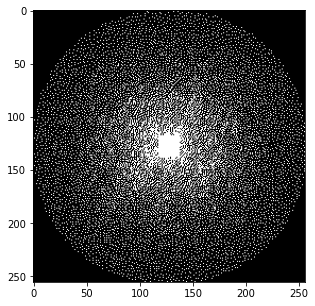

In [47]:
#Example sampling for a single accelerating factor

acc=(6) #Float Target acceleration factor. Must be greater than 1.
shape_calib=20 # Size of the calibration window.
shape_z=ksp_phantom.shape[1]
shape_y=ksp_phantom.shape[2]

random_seed = 42
file_name = './mask_logan_r%0.2g_c%d.npy' % (acc, shape_calib)
print('Creating mask (%s)...' % file_name)

mask = poisson(img_shape=[shape_z, shape_y], accel=acc, 
               max_attempts =15, tol=0.5, 
               calib=(shape_calib, shape_calib))

np.save(file_name, mask.astype(np.complex64))

plt.imshow(np.abs(np.real(mask)),cmap='gray')

plt.show()

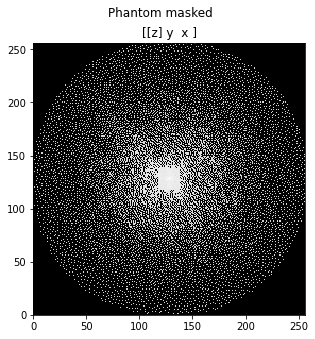

In [48]:
ksp_phantom_masked = ksp_phantom * mask

pl.ImagePlot(np.log(np.abs(ksp_phantom_masked)+1e-16), z=0, title='Phantom masked')

plt.show()

* `acc` permet de jouer sur la dispersion du masque, autrement dit, la quantité de points à l'exterieur du centre.
* `shape_calib` permet de jouer sur la taille du carré central du masque


### 3.3

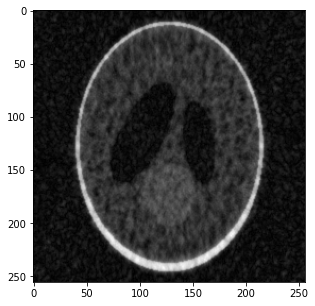

In [49]:
image_recons = np.sum(np.abs(sp.ifft(ksp_phantom_masked, axes=(-1,-2)))**2,axis=0)**0.5

plt.imshow(image_recons, cmap='gray')

plt.show()

On observe des artefacts sur l'image reconstruite causés par l'application du masque qui a mis à zéro plusieurs coefficients de la transformée de fourier.

### 3.4

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

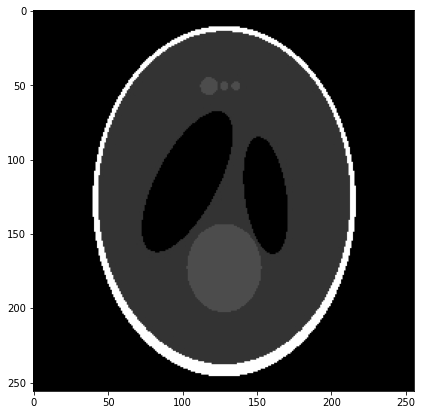

In [55]:
mps_phantom = np.ones((1, 256, 256))
lambda_ = 0.0005
wavelet_recons = sp.mri.app.L1WaveletRecon(ksp_phantom, mps_phantom, lambda_)
img_recons = wavelet_recons.run()

plt.imshow(np.abs(img_recons), cmap='gray')

plt.show()

Le critère optimisé est : 

$$ \frac{1}{2} \lVert PFSx - y \rVert^2_2 + \lambda \lVert Wx \rVert_1 $$

Avec :

* $y$  : kspace
* $P$ : opérateur de sampling
* $F$ : opérateur de transformée en fourier
* $W$ : opérateur de transformée en ondelettes
* $\lambda$ : paramètre de régularisation

### 3.5

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

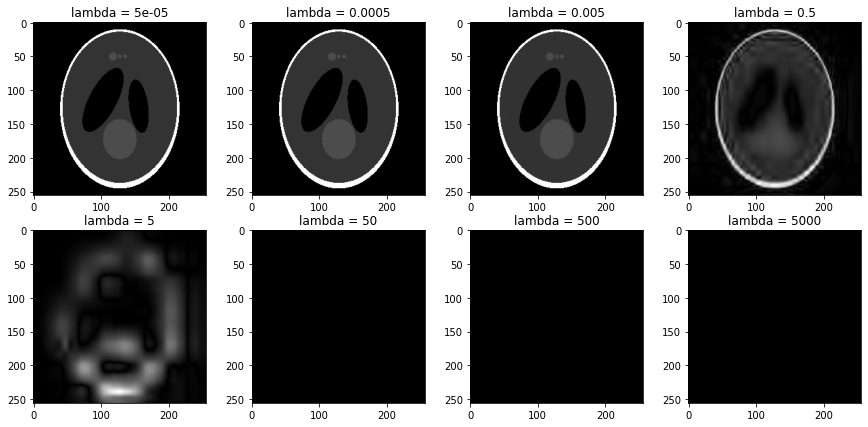

In [52]:
lamda = (0.00005, 0.0005, 0.005,0.5, 5, 50, 500, 5000)
plt.rcParams["figure.figsize"] = (15,7)

for i, l in enumerate(lamda):
    wavelet_recons = sp.mri.app.L1WaveletRecon(ksp_phantom,mps_phantom,l)
    img_recons = wavelet_recons.run()
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.abs(img_recons), cmap='gray')
    plt.title(f"lambda = {l}")
plt.show()

In [59]:
original = np.abs(sp.ifft(ksp_phantom, axes=(-1,-2)))[0]

for lambda_ in lamda:
    wavelet_recons = sp.mri.app.L1WaveletRecon(ksp_phantom,mps_phantom,lambda_)
    compressed = wavelet_recons.run()
    psnr = PSNR(original, compressed)
    print(f"lambda = {lambda_} - PSNR = {psnr}")

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 5e-05 - PSNR = 91.4058495759086


/tmp/ipykernel_121687/3009363345.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  psnr = 20 * log10(max_pixel / sqrt(mse))


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0.0005 - PSNR = 71.72634258213904


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0.005 - PSNR = 52.648699372954574


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0.5 - PSNR = 21.269635133914235


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 5 - PSNR = 13.622074360452235


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 50 - PSNR = 12.131081815228377


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 500 - PSNR = 12.131081815228377


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 5000 - PSNR = 12.131081815228377


On observe alors que $\lambda = 0.0005$ permet de maximiser le PSNR.

### 3.6

On observe ainsi que pour de bonnes valeurs de $\lambda$, la reconstruction à partir du dataset échantillonné est très semblable à celle obtenue à partir du dataset entier. En choisissant une bonne valeur du paramètre de régularisation on peut donc se contenter du dataset échantillonné.

## 4. Compressed Sensing on invivo/brain

### 4. **Compressed sensing** of the in-vivo brain dataset

For the invivo brain dataset we only have access to the sampled data (no full acquisition). However, different to the phantom, this dataset is multi-parallel and can make use of sensitivity maps for reconstruction.


**4.1.** Reconstruct the MR image using the direct reconstruction for each channel. What do you observe? 


**4.2.** Single reconstruction from a mutiparallel acquisition

   a) Describe how multiparallel MRI data differs from traditional MRI?
   
   b) Use the **Root-Sum-of-Squares reconstruction (RSS)** to recover a single MR image from the multichannel and sampled dataset. Consider the non sampled coefficients to be zero. 

$$
    I_{\rm RSS} = 
    \sqrt{
    \sum_{n=1}^{N {\rm channels}} IFFT(ksp)^2
    }
$$

       
**4.3.** Reconstruction with **sensitivity maps**

   a) What is a sensitivity map?, what are sensitivity maps useful for?

   b) Compute and display the **sensitivity maps** for the in-vivo brain dataset using the ESPIRIT app from sigpy. What do you observe?

   c) Use the mri.apps to do the reconstruction of the **brain dataset** using the SENSE method using the computed sensitivity maps
  
   d) Look at the documentation, what criteria is being optimized here?
   
   e) Change the regularization parameters of each method and discuss how they change the qualitative results


**4.4.** **Regularized reconstructions**

   a) Use the mri.apps to do the reconstruction of the **brain dataset** using the following methods
        - Wavelet L1 Reconstruction
        - Total Variation Reconstruction
        
   b) Look at the documentation of each method and explain the problem solved in each case. 
   
   c) Change the regularization parameters of each method and discuss how they change the qualitative results

### 4.1

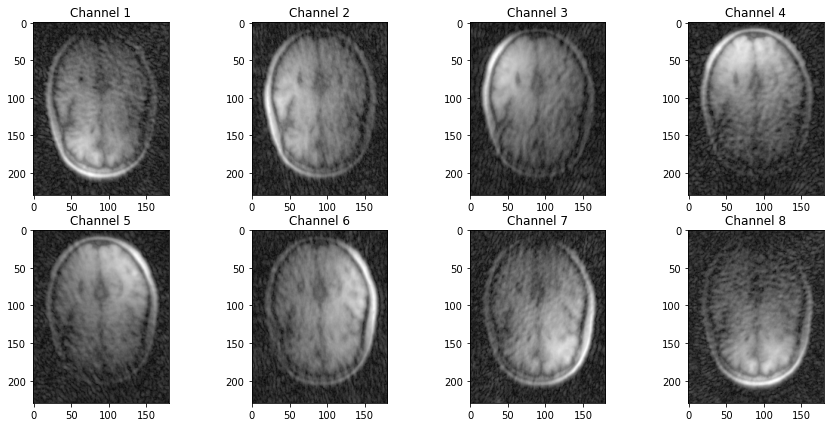

In [60]:
for i in range(8):
    image_recons = np.abs(sp.ifft(ksp[i], axes=(-1,-2)))**0.5
    
    plt.subplot(2, 4, i + 1)
    plt.title(f'Channel {i + 1}')
    plt.imshow(image_recons, cmap='gray')
    
plt.show()

On observe alors que les images obtenues varient entre les différents canaux, il convient alors de combiner ces résultats pour obtenir une unique image.

### 4.2

In [ ]:
ksp_ifft = sp.ifft(ksp, axes=(-1, -2))
image_recons = np.sum(np.abs(ksp_ifft), axis=0) ** 0.5

plt.imshow(image_recons, cmap='gray')

plt.show()

#### Sensitivity maps

To perform parallel imaging reconstruction of the multi-parallel data, we will use the ESPIRiT method to estimate first the sensitivity maps. To do this, we can use the [EspiritCalib](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.EspiritCalib.html#sigpy.mri.app.EspiritCalib) App from sigpy.

To run an App, you simply do `app.run()`. You should be able to see a progress bar showing the `App`'s progress. 

In [ ]:
# Sensitivity maps

mps_phantom = mr.app.EspiritCalib(ksp_phantom).run()

mps = mr.app.EspiritCalib(ksp).run()

In [ ]:
pl.ImagePlot( mps_phantom, title="Log Phantom" )
plt.show()

pl.ImagePlot( mps, z=0, title="Log Phantom" )
plt.show()

#### Reconstructions

Hint: Use the optimization apps  https://sigpy.readthedocs.io/en/latest/mri_app.html

To run an App, you simply do `app.run()`. You should be able to see a progress bar showing the `App`'s progress. 


In [ ]:
lambda_ = 0.01

image_recons = mr.app.SenseRecon(ksp, mps, lambda_).run()

pl.ImagePlot(image_recons)

In [ ]:
lambda_ = 0.01

image_recons = mr.app.L1WaveletRecon(ksp, mps, lambda_).run()

pl.ImagePlot(image_recons)

In [ ]:
lambda_ = 0.01

image_recons = mr.app.TotalVariationRecon(ksp, mps, lambda_).run()

pl.ImagePlot(image_recons)